### Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import emoji

### Loading the data

In [2]:
df = pd.read_csv("C:/Users/joelk/automated-review-rating-system/data/Kaggle Datasets/Disneyland_Reviews.csv", encoding="latin1")

### Data structures

In [3]:
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
df.tail()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris
42655,1536786,4,missing,United Kingdom,"I went to the Disneyparis resort, in 1996, wit...",Disneyland_Paris


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
df.isnull().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

### Removing Duplicates

In [7]:
df = df.drop_duplicates(subset=['Review_Text', 'Rating'])

In [8]:
df.shape

(42633, 6)

In [9]:
conflicts = df.groupby('Review_Text')['Rating'].nunique()
conflicting_reviews = conflicts[conflicts > 1].index
print("Number of reviews with conflicting ratings:", len(conflicting_reviews))

Number of reviews with conflicting ratings: 1


In [10]:
df = df[~df['Review_Text'].isin(conflicting_reviews)]

In [11]:
df.shape

(42631, 6)

### Removing Unnecessary Columns

In [12]:
df = df.drop('Review_ID', axis=1)

In [13]:
df = df.drop('Reviewer_Location', axis=1)

### Normalizing "review_text" column

In [14]:
def normalize_review(text):
   
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    if not isinstance(text, str):
        return None

    # Converting all reviews into Lowercase
    text = text.lower()

    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Removing URls
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Removing punctuation and special characters
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Removing Emojis
    text = text.encode("ascii","ignore").decode("ascii")

    # Tokenizing the reveiews
    tokens = text.split()

    # Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Filtering Too short and long reviews
    if len(tokens) < 3 or len(tokens) > 100: # the longest review has a word count of 970. but the average, median, Q3 of wordcount was 66,52,77 respectievlely. 
        return None

    return " ".join(tokens)

In [15]:
df['cleaned_review'] = df['Review_Text'].apply(normalize_review)

In [16]:
df = df.dropna(subset=['cleaned_review'])

In [17]:
df

,Rating,Year_Month,Review_Text,Branch,cleaned_review
0,4,2019-4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,youve ever disneyland anywhere youll find disn...
2,4,2019-4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god hot humid visiting park otherwise w...
3,4,2019-4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland great compact park unfortunately...
4,4,2019-4,"the location is not in the city, took around 1...",Disneyland_HongKong,location city took around 1 hour kowlon kid li...
5,3,2019-4,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong,disney world disneyland anaheim tokyo disneyla...
...,...,...,...,...,...
42651,5,missing,i went to disneyland paris in july 03 and thou...,Disneyland_Paris,went disneyland paris july 03 thought brillian...
42652,5,missing,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris,2 adult 1 child 11 visited disneyland paris be...
42653,5,missing,My eleven year old daughter and myself went to...,Disneyland_Paris,eleven year old daughter went visit son london...
42654,4,missing,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris,hotel part disneyland paris complex wonderful ...


In [18]:
df.shape

(34987, 5)

### Visualization

C:\Users\joelk\AppData\Local\Temp\ipykernel_18524\3511575154.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis', order=sorted(df['Rating'].unique()))


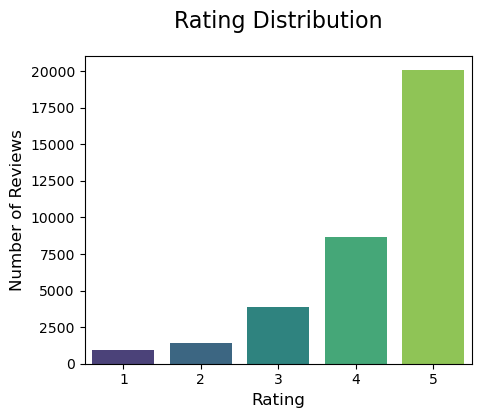

In [19]:
plt.figure(figsize=(5,4))
sns.countplot(x='Rating', data=df, palette='viridis', order=sorted(df['Rating'].unique()))
plt.title("Rating Distribution", fontsize=16, pad=20)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()

In [20]:
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))

In [21]:
df

,Rating,Year_Month,Review_Text,Branch,cleaned_review,word_count
0,4,2019-4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,youve ever disneyland anywhere youll find disn...,33
2,4,2019-4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god hot humid visiting park otherwise w...,82
3,4,2019-4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland great compact park unfortunately...,46
4,4,2019-4,"the location is not in the city, took around 1...",Disneyland_HongKong,location city took around 1 hour kowlon kid li...,18
5,3,2019-4,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong,disney world disneyland anaheim tokyo disneyla...,87
...,...,...,...,...,...,...
42651,5,missing,i went to disneyland paris in july 03 and thou...,Disneyland_Paris,went disneyland paris july 03 thought brillian...,84
42652,5,missing,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris,2 adult 1 child 11 visited disneyland paris be...,94
42653,5,missing,My eleven year old daughter and myself went to...,Disneyland_Paris,eleven year old daughter went visit son london...,54
42654,4,missing,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris,hotel part disneyland paris complex wonderful ...,62


In [22]:
df['word_count'].describe()

count    34987.000000
mean        39.876040
std         23.706727
min          3.000000
25%         21.000000
50%         34.000000
75%         55.000000
max        100.000000
Name: word_count, dtype: float64

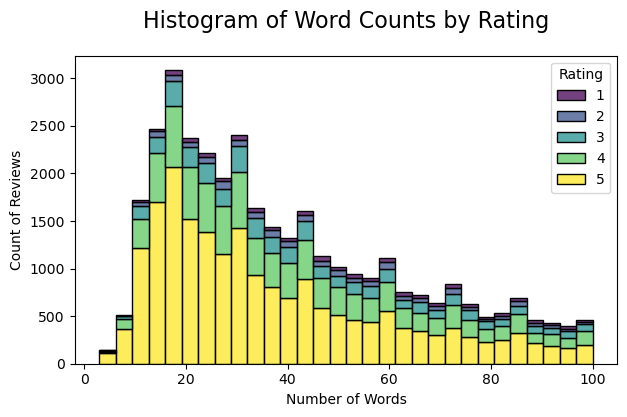

In [23]:
plt.figure(figsize=(7,4))
sns.histplot(data=df, x="word_count", hue="Rating", bins=30, multiple="stack", palette="viridis")
plt.title("Histogram of Word Counts by Rating", fontsize=16, pad=20)
plt.xlabel("Number of Words")
plt.ylabel("Count of Reviews")
plt.show()

In [24]:
for rating in sorted(df["Rating"].unique()):
    print(f"\n======================= Rating: {rating} =======================\n")
    sample_reviews = df[df["Rating"] == rating]["Review_Text"].sample(n=5, random_state=42)  
    for i, review in enumerate(sample_reviews, 1):
        print(f"{i}. {review}\n")


======================= Rating: 1 =======================

1. My partner recently stayed with you, as a teacher on a school trip. He spoke highly of your service, and the attractions. Whilst his stay he bought me a mikey and minnie photo frame as a gift to bring home. Though when he got it home, I discovered the shocking quality of this product. The material was peeling of the back and stand, the paint work looks like it's been done by a toddler with a crayon, and the general quality of the product is just disgraceful.I would advise in future you review the quality of the products for sale in your resort shops, to avoid further disappointment. Your shabby photo frame ruined what was supposed to be a romantic gesture. Well done disney. 

2. After visiting all of the Disneylands and worlds around the globe we feel we are more than qualified to write a review for this particular one.It is definitely the worst of them all. Longest lines we have ever seen (on the rides that were open). Not

In [25]:
df['Rating'].value_counts().sort_index()

Rating
1      964
2     1432
3     3873
4     8673
5    20045
Name: count, dtype: int64

### Resampling Ratings with samples lesser than 2000

In [26]:
from sklearn.utils import resample

# target min samples per class
min_samples = 2000  

df_imbalanced_sampled = df.copy()
new_dfs = []

for rating, group in df_imbalanced_sampled.groupby("Rating"):
    if len(group) < min_samples:
        # Upsample minority class
        group = resample(group, 
                         replace=True, 
                         n_samples=min_samples, 
                         random_state=42)
    new_dfs.append(group)

df_imbalanced_sampled = pd.concat(new_dfs)
print(df_imbalanced_sampled['Rating'].value_counts().sort_index())


Rating
1     2000
2     2000
3     3873
4     8673
5    20045
Name: count, dtype: int64


C:\Users\joelk\AppData\Local\Temp\ipykernel_18524\2529375585.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df_imbalanced_sampled, palette='viridis', order=sorted(df_imbalanced_sampled['Rating'].unique()))


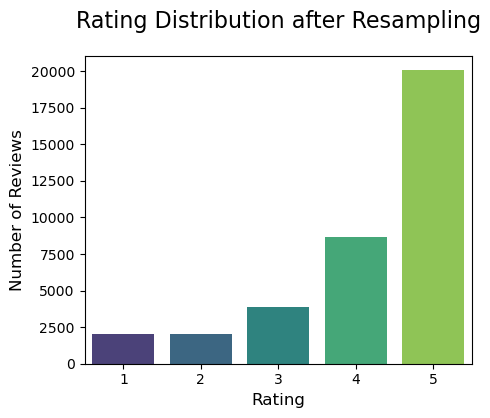

In [27]:
plt.figure(figsize=(5,4))
sns.countplot(x='Rating', data=df_imbalanced_sampled, palette='viridis', order=sorted(df_imbalanced_sampled['Rating'].unique()))
plt.title("Rating Distribution after Resampling", fontsize=16, pad=20)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()

### Train Test Splitting

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x = df_imbalanced_sampled['cleaned_review']
y = df_imbalanced_sampled['Rating']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
print("Training set class distribution:")
print(y_train.value_counts())

Training set class distribution:
Rating
5    16036
4     6938
3     3098
1     1600
2     1600
Name: count, dtype: int64


In [31]:
print("\nTest set class distribution:")
print(y_test.value_counts())


Test set class distribution:
Rating
5    4009
4    1735
3     775
1     400
2     400
Name: count, dtype: int64


In [32]:
# Appying preprocessing to train test sets

x_train_clean = x_train.apply(normalize_review)
x_test_clean  = x_test.apply(normalize_review)

#Removing rows that didn't pass the preprocessing
train_mask = x_train_clean.notna()
test_mask  = x_test_clean.notna()

x_train_clean, y_train = x_train_clean[train_mask], y_train[train_mask]
x_test_clean, y_test   = x_test_clean[test_mask], y_test[test_mask]

In [33]:
df_new = pd.DataFrame({
    'cleaned_review': x_test_clean,
    'rating': y_test
})

# Export to CSV
output_filename = 'imbalanced_test_set.csv'
df_new.to_csv(output_filename, index=False)

### Vectorization

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_B = TfidfVectorizer(max_features=15000,
                             ngram_range=(1,2))
                            

# fitting on training data
x_train_vec = vectorizer_B.fit_transform(x_train_clean)

# Transforming the test data
x_test_vec = vectorizer_B.transform(x_test_clean)

print(x_train_vec.shape, x_test_vec.shape)

(29272, 15000) (7319, 15000)


# Model Building

## Logistic Regression

#### Importing Libraries

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### Initiating model

In [36]:
lr_model = LogisticRegression(C=1.0,
                             solver='lbfgs',
                             multi_class='multinomial',
                             max_iter=100)

#### Training model

In [37]:
lr_model.fit(x_train_vec, y_train)

C:\Users\joelk\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\joelk\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

#### Making predictions on test data

In [38]:
y_pred_lr = lr_model.predict(x_test_vec)

#### Evaluating Model

In [39]:
#Accuracy 
accuracy_lr = accuracy_score(y_test, y_pred_lr)

#Precision
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')

#Recall
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

#f1
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

#confusion matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\nAccuracy       : ",accuracy_lr)
print("Precision      : ",precision_lr)
print("Recall         : ",recall_lr)
print("F1 Score       : ",f1_lr)
print("\nConfusion Matrix : \n",cm_lr)


Accuracy       :  0.6727695040306053
Precision      :  0.6465433771599194
Recall         :  0.6727695040306053
F1 Score       :  0.645081936301779

Confusion Matrix : 
 [[ 303   16   29   16   36]
 [  29  161   78   54   78]
 [  29   30  225  265  226]
 [  19    2   85  582 1047]
 [   6    2   33  315 3653]]


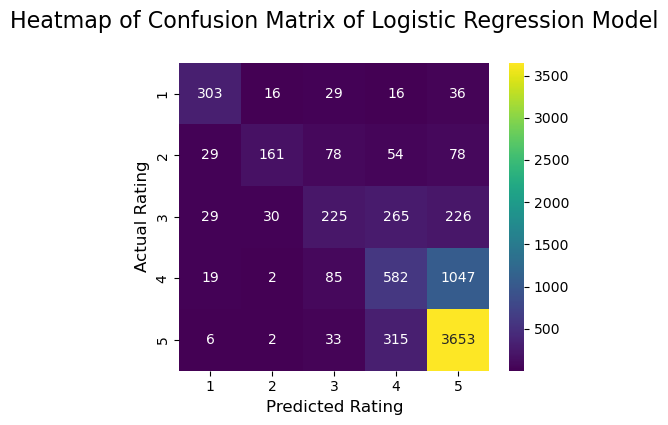

In [40]:
labels = [1,2,3,4,5]

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Actual Rating", fontsize=12)
plt.title("Heatmap of Confusion Matrix of Logistic Regression Model", fontsize=16, pad=25)
plt.show()

In [41]:
train_accuracy = lr_model.score(x_train_vec, y_train)
test_accuracy = lr_model.score(x_test_vec, y_test)
print("training data accuracy : ",train_accuracy)
print("testing data accuracy : ",test_accuracy)

training data accuracy :  0.7930787100300628
testing data accuracy :  0.6727695040306053


### Inferences

* The model performs well on Rating 1 & 5.
* Middle ratings are more confused.
* Bias towards rating 5 :
  You can see many reviews for middle ratings (3,4) are predicted as rating 5.




## Random Forest Classifier

#### Importing Libraries

In [42]:
from sklearn.ensemble import RandomForestClassifier

#### Initiating model

In [43]:
rf_model = RandomForestClassifier(n_estimators=50,
                                  random_state=42)
                                  #max_depth=30,
                                  #min_samples_split=5,
                                  #min_samples_leaf=2)

#### Training model

In [44]:
rf_model.fit(x_train_vec, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

#### Making Predictions

In [45]:
y_pred_rf = rf_model.predict(x_test_vec)

In [46]:
#Accuracy 
accuracy_rf = accuracy_score(y_test, y_pred_rf)

#Precision
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')

#Recall
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

#f1
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

#confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nAccuracy       : ",accuracy_rf)
print("Precision      : ",precision_rf)
print("Recall         : ",recall_rf)
print("F1 Score       : ",f1_rf)
print("\nConfusion Matrix : \n",cm_rf)


Accuracy       :  0.6436671676458533
Precision      :  0.6034564541941422
Recall         :  0.6436671676458533
F1 Score       :  0.551638958061632

Confusion Matrix : 
 [[ 332    0    3   15   50]
 [   3  283    7   11   96]
 [   0    0   22  139  614]
 [   0    0    4  147 1584]
 [   0    0    1   81 3927]]


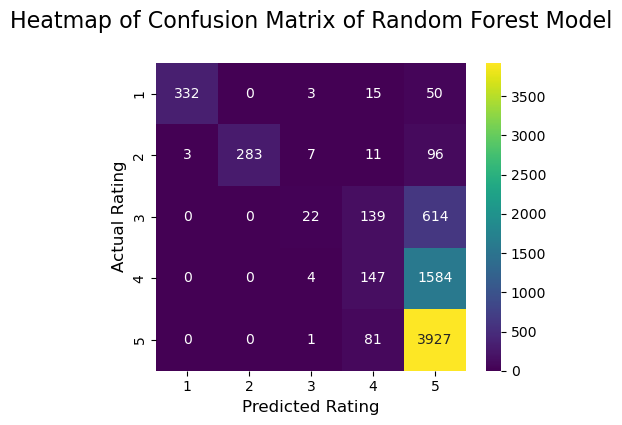

In [47]:
labels = [1,2,3,4,5]

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Actual Rating", fontsize=12)
plt.title("Heatmap of Confusion Matrix of Random Forest Model", fontsize=16, pad=25)
plt.show()

### Inferences 

* The Model is highly biased towards higher ratings:
  The model heavily leans toward predicting higher ratings, confusing many 4-star Rating as 5-star.
* Rating 1 & 2 are classified fairly well, showing that the model can capture clear negative sentiment patterns.
* Rating 3 is more difficult for the model to distinguish (Overlapping with both positive & negative reiews.
  

## SVM (Support Vector Machine)

#### Importing Libraries

In [48]:
from sklearn.svm import LinearSVC

#### Initiating Model

In [49]:
#model_B = svm_model
model_B = LinearSVC(random_state=42,
                     C=0.5,
                     max_iter=2000)
                     #class_weight='balanced')

#### Training Model

In [50]:
model_B.fit(x_train_vec, y_train)

LinearSVC(C=0.5, max_iter=2000, random_state=42)

In [51]:
y_pred_svm = model_B.predict(x_test_vec)

In [52]:
import joblib

joblib.dump(model_B, "Model_B.pkl")
joblib.dump(vectorizer_B, "Vec_B.pkl")

['Vec_B.pkl']

#### Evaluation of Model

In [53]:
#Accuracy 
accuracy_svm = accuracy_score(y_test, y_pred_svm)

#Precision
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')

#Recall
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

#f1
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

#confusion matrix

cm_svm = confusion_matrix(y_test, y_pred_svm)

print("\nAccuracy       : ",accuracy_svm)
print("Precision      : ",precision_svm)
print("Recall         : ",recall_svm)
print("F1 Score       : ",f1_svm)
print("\nConfusion Matrix : \n",cm_svm)


Accuracy       :  0.6775515780844378
Precision      :  0.6476639788933203
Recall         :  0.6775515780844378
F1 Score       :  0.6526429499591827

Confusion Matrix : 
 [[ 346    9   19   10   16]
 [  22  274   43   25   36]
 [  41   45  219  262  208]
 [  23   10  113  559 1030]
 [  13    4   52  379 3561]]


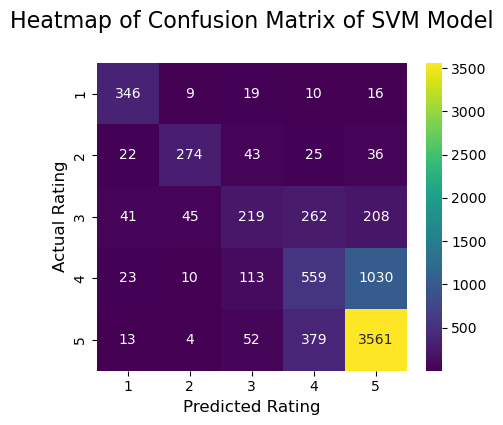

In [54]:
labels = [1,2,3,4,5]

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Actual Rating", fontsize=12)
plt.title("Heatmap of Confusion Matrix of SVM Model", fontsize=16, pad=25)
plt.show()

### Inferences

* The model performs very well for Rating 1 & 5, correctly identifying most of them.
* Middle Ratings 2, 3 and 4 show lower accuracy.
* Misclassification between adjacent ratings. 

### Conslusion

After evaluating Logistic Regression, Random Forest, and SVM on the imbalanced review dataset, SVM emerges as the optimal model with the highest accuracy (67.7%).

In [55]:
import numpy as np

results_df = pd.DataFrame({
    "Review": x_test_clean,
    "Actual Rating": y_test,
    "Predicted Rating": y_pred_svm
}).reset_index(drop=True)

sampled_reviews = (
    results_df.groupby("Actual Rating", group_keys=False)
    .apply(lambda x: x.sample(n=5, random_state=42) if len(x) >= 5 else x)
    .reset_index(drop=True)
)

sampled_reviews.index = np.arange(1, len(sampled_reviews) + 1)
sampled_reviews.index.name = "S.No"

sampled_reviews



C:\Users\joelk\AppData\Local\Temp\ipykernel_18524\1355176769.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, random_state=42) if len(x) >= 5 else x)


,Review,Actual Rating,Predicted Rating
S.No,,,
1,go florida park serious wasp issue ques ridicu...,1,1
2,overall actually love disneyland pretty great ...,1,1
3,horrible experince three year old daughter cro...,1,1
4,may 20 21 visited disneyland ca adventure cele...,1,2
5,went park school still try avoid crowd unsucce...,1,1
6,comparison bigger sister florida parc small ri...,2,4
7,disneyland disappointing huge crowd long wait ...,2,2
8,visited disney paris waste time money knew wou...,2,2
9,came disney weekend stayed hotel nearby enjoy ...,2,2
